In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [2]:
tf.enable_eager_execution()


execfile("definitions.py")

train_batch_size = 4
num_steps = 10
num_features = 512
state_size = 128
noise_rms = 0.01

checkpoint_path_1 = "checkpoints/model1_512"
checkpoint_path_2 = "checkpoints/model2_512"


In [3]:
sk_gen = SRC_KAPPA_Generator(train_batch_size=train_batch_size,test_batch_size=train_batch_size,kap_side_length=20.48, num_src_side=num_features,num_kappa_side=num_features)
lens_util_obj = lens_util(im_side= 3., numpix_side = num_features ,kap_side=20.48,  method = "Unet")

physical_model = lens_util_obj.physical_model

In [4]:
sk_gen.draw_k_s("train")

tf_source =  tf.identity(sk_gen.Source_tr[:,:,:,:])
tf_kappa  = tf.identity(sk_gen.Kappa_tr[:,:,:,:] )

In [5]:
execfile("genSIEdef_angles.py")

In [15]:
xim, yim = np.meshgrid( np.linspace(-10.24,10.24,512)*  np.pi / 180 / 3600, np.linspace(-10.24,10.24,512) * np.pi / 180 / 3600)
x_alpha = np.zeros((train_batch_size,num_features, num_features,1))
y_alpha = np.zeros((train_batch_size,num_features, num_features,1))
np.random.seed(seed=136)
for i in range(train_batch_size):
    xlens = np.random.uniform(low=-1.0, high=1.)
    ylens = np.random.uniform(low=-1.0, high=1.)
    elp = np.random.uniform(low=0.01, high=0.6)
    phi = np.random.uniform(low=0.0, high=2.*np.pi)
    Rein = np.random.uniform(low=0.5, high = 7)
    x_alpha[i,:,:,0] , y_alpha[i,:,:,0]  = raytrace(xim,yim,[Rein, elp , phi*180/np.pi  , xlens , ylens])
    
    sk_gen.Kappa_tr[i,:,:,0] = sk_gen.Kappa_fun(xlens, ylens, elp, phi, Rein)
x_alpha = x_alpha/(  np.pi / 180 / 3600)
y_alpha = y_alpha/(  np.pi / 180 / 3600)
tf_kappa  = tf.identity(sk_gen.Kappa_tr[:,:,:,:] )

In [16]:
IM = physical_model(  sk_gen.Source_tr[:,:,:,:],sk_gen.Kappa_tr[:,:,:,:])

In [17]:
Xsrc = tf.add(tf.reshape(lens_util_obj.Xim, [-1, num_features, num_features, 1]),   x_alpha )
Ysrc = tf.add(tf.reshape(lens_util_obj.Yim, [-1, num_features, num_features, 1]),   y_alpha )
Xsrc = tf.cast( Xsrc,tf.float32)
Ysrc = tf.cast( Ysrc,tf.float32)

In [18]:
IM2=lens_util_obj.lens_source( Xsrc, Ysrc, sk_gen.Source_tr)

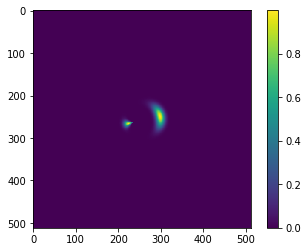

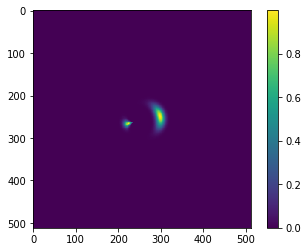

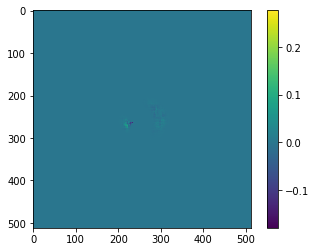

In [32]:
ind=3
plt.imshow(IM2[ind,:,:,0])
plt.colorbar()
plt.figure()
plt.imshow(IM[ind,:,:,0])
plt.colorbar()
plt.figure()
plt.imshow(IM[ind,:,:,0]-IM2[ind,:,:,0])
plt.colorbar()

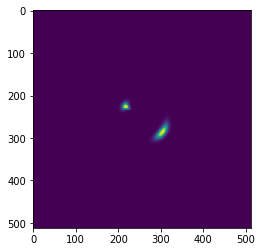

In [20]:
plt.imshow(IM[0,:,:,0])

In [12]:
xsrc,ysrc,ax,ay = lens_util_obj.get_deflection_angles(tf_kappa)

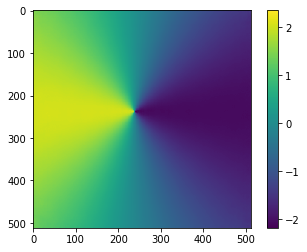

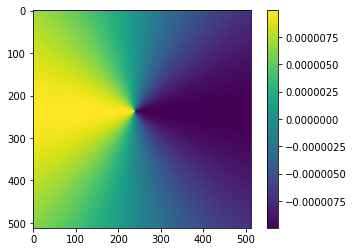

In [14]:
plt.imshow(ax[0,:,:,0])
plt.colorbar()
plt.figure()
plt.imshow(x_alpha[0,:,:,0])
plt.colorbar()

In [1]:
import sys
sys.path = ['', '/cm/shared/sw/pkg-old/devel/python2/2.7.13/lib/python27.zip', '/cm/shared/sw/pkg-old/devel/python2/2.7.13/lib/python2.7', '/cm/shared/sw/pkg-old/devel/python2/2.7.13/lib/python2.7/plat-linux2', '/cm/shared/sw/pkg-old/devel/python2/2.7.13/lib/python2.7/lib-tk', '/cm/shared/sw/pkg-old/devel/python2/2.7.13/lib/python2.7/lib-old', '/cm/shared/sw/pkg-old/devel/python2/2.7.13/lib/python2.7/lib-dynload', '/cm/shared/sw/pkg-old/devel/python2/2.7.13/lib/python2.7/site-packages', '/cm/shared/sw/pkg-old/devel/python2/2.7.13/lib/python2.7/site-packages/IPython/extensions', '/mnt/home/yhezaveh/.ipython'] + sys.path


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
tf.enable_eager_execution()

/cm/shared/sw/pkg-old/devel/python2/2.7.13/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


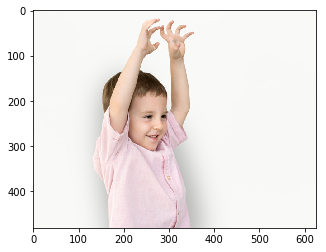

In [3]:
import urllib2
import cStringIO
from PIL import Image
import matplotlib.pyplot as plt

%matplotlib inline


url='https://www.ibiblio.org/hyperwar/USA/USA-EF-Defeat/maps/USA-EF-Defeat-40.jpg'
im = Image.open('little-boy-hands-up-cute-adorable-cheerful_53876-38301.jpg')
plt.imshow(im, cmap='Greys_r')

In [4]:
m = plt.imread('little-boy-hands-up-cute-adorable-cheerful_53876-38301.jpg', format='jpeg')

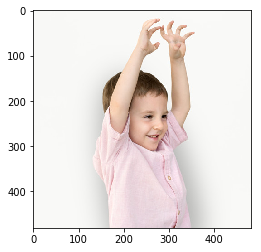

In [5]:
plt.imshow(m[:, :481,:], cmap='Greys_r')

TensorShape([Dimension(1), Dimension(481), Dimension(481), Dimension(1)])

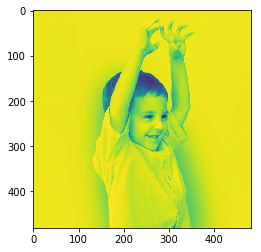

In [25]:
plt.imshow(Src[0,:,:,0])
Src.shape

In [6]:
execfile("definitions.py")

train_batch_size = 1
num_steps = 10
num_features = 481
state_size = 128
noise_rms = 0.01



In [26]:
lens_util_obj = lens_util(src_side=20.48,im_side= 20.48, numpix_side = num_features ,kap_side=20.48)

In [27]:
Kappa_tr = np.zeros((train_batch_size,num_features,num_features,1),dtype='float32')

In [28]:
x_k = np.linspace(-1., 1., num_features,dtype='float32') * 20.48/2.
Xkap, Ykap = np.meshgrid(x_k, x_k)

In [40]:
Kappa_tr = np.cos(Ykap*0.4+1)

In [48]:
Src= tf.cast(m[:, :481,2].reshape(1,481,481,1).T, tf.float32)
Kappa_tr = Kappa_tr.reshape(1,481,481,1)

In [49]:
IM3 = lens_util_obj.physical_model(  Src, Kappa_tr)

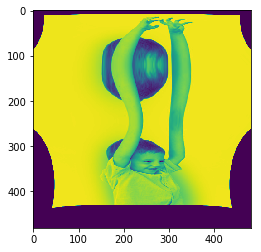

In [50]:
plt.imshow(IM2.numpy()[0,:,:,0])

In [15]:
Xsrc, Ysrc , alpha_x , alpha_y = lens_util_obj.get_deflection_angles( Kappa_tr)

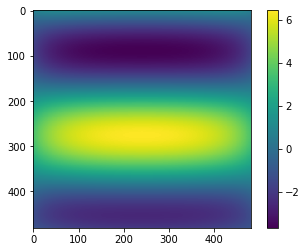

In [21]:
plt.imshow(alpha_y.numpy()[0,:,:,0])
plt.colorbar()

In [53]:
IMRGB = tf.stack([IM, IM2, IM3],axis=3)

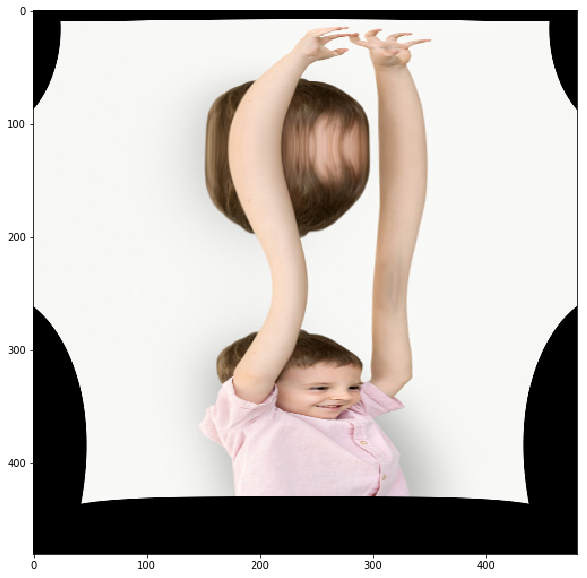

In [72]:
plt.subplots(1,1,figsize=(10,10))
plt.imshow(IM_npRGB[0,:, :,:,0], cmap='Greys_r')
# plt.figure(figsize=(100,100))

In [59]:
IM_npRGB = IMRGB.numpy()

In [60]:
IM_npRGB = IM_npRGB/np.max(IM_npRGB)